<center><img style="width:auto; height:auto;" src = "https://raw.githubusercontent.com/AlikMon88/FillerStack-repo/ebb777f8f116d4a79e69c67705179b641328ed42/extra/transformers.gif" /></center> 


In [2]:
import pandas as pd
from pprint import pprint
import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('../input/emotion-detection-from-text/tweet_emotions.csv')

print('No. of Tweets: ',data.shape[0])
print(data.isnull().sum())
print()
print('-- Sentiment-Count --')
print()
print(data.sentiment.value_counts())
print()
all_classes = data.sentiment.unique().tolist()

pprint(all_classes)

data.head()

No. of Tweets:  40000
tweet_id     0
sentiment    0
content      0
dtype: int64

-- Sentiment-Count --

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


<h2 style="background-color:black; color:white; text-align:center;"><b><i> Data Balancing & Preprocessing </i></b></h2> 

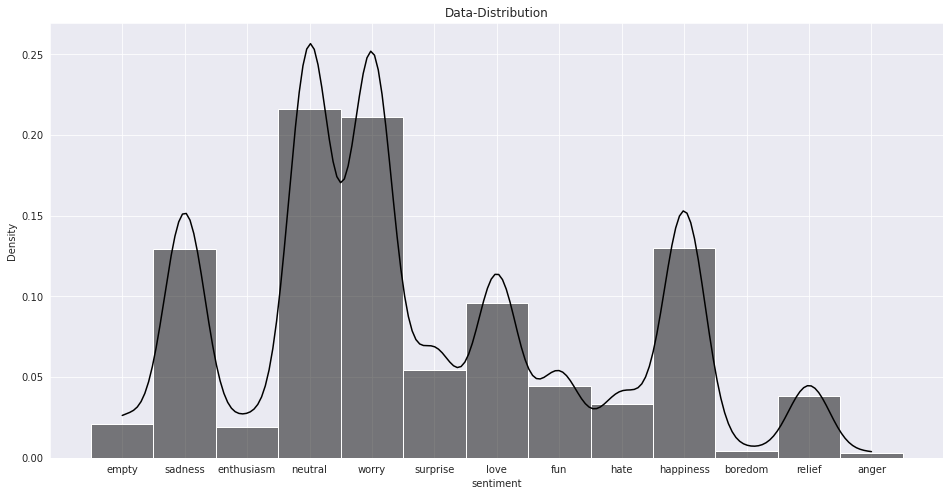

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style('darkgrid')

plt.figure(figsize=(16,8))
plt.title('Data-Distribution')
sns.histplot(data['sentiment'], kde=True, color='black', stat='density')
plt.show()


**Its pretty evident that we have a very limited data, so this will definetely be a bottleneck in the learning process**

In [4]:
''' Resampling -- Another Approach to tackle Imbalance '''

from sklearn.utils import resample

maxx = 3
target_majority = data[data.sentiment==all_classes[maxx]]

#min_class = [0, 2, 5, 7, 8, 10, 11, 12]

for cl in range(13):
    train_minority = data[data.sentiment==all_classes[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=123)
    if cl == 0:
        train_upsampled = pd.concat([train_minority_upsampled, target_majority])
        #train_upsampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=maxx:
        train_upsampled = pd.concat([train_minority_upsampled, train_upsampled])

train_upsampled['sentiment'].value_counts() 
#'''

anger         8638
relief        8638
boredom       8638
happiness     8638
hate          8638
fun           8638
love          8638
surprise      8638
worry         8638
enthusiasm    8638
sadness       8638
empty         8638
neutral       8638
Name: sentiment, dtype: int64

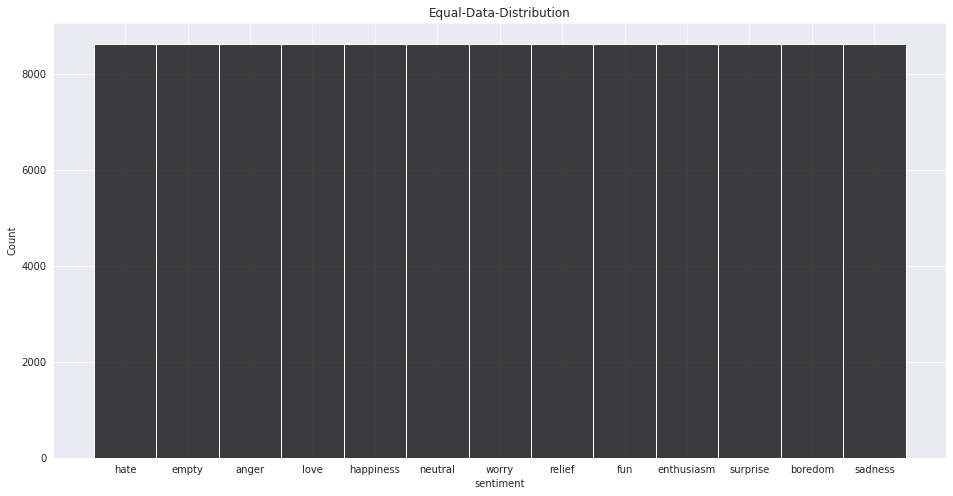

In [5]:
data = train_upsampled.sample(frac=1).reset_index(drop=True)
plt.figure(figsize=(16,8))
plt.title('Equal-Data-Distribution')
sns.histplot(data['sentiment'], kde=False, color='black', stat='count')
plt.show()

In [6]:
import string
import numpy as np
import tensorflow as tf

content_text = data.content.tolist()
all_classes = data.sentiment.unique().tolist()

'''

token_data = tf.keras.preprocessing.text.Tokenizer(num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ')

token_data.fit_on_texts(content_text)
ind_text = token_data.texts_to_sequences(content_text)'''


content_text = data.content.tolist()
ex_char = string.punctuation
ex_char = ex_char.replace('~', '')
c_text = '~~~~~~'.join(content_text)

x = c_text.translate(str.maketrans('', '', ex_char))
c_text = x.split('~~~~~~')

print('Again_samples: ',len(c_text))
print('Some_Sentences: ')
print()
print(c_text[34])
print(c_text[21])
print()

token_data = tf.keras.preprocessing.text.Tokenizer(num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ')
token_data.fit_on_texts(c_text)
ind_text = token_data.texts_to_sequences(c_text)

print()

print('All_samples: ', len(ind_text))
word_index = token_data.word_index
print('Diff. words: ', len(list(word_index)))


Again_samples:  112294
Some_Sentences: 

fuckinm transtelecom
RavenLaR Sok trying to plot alternatives as we speak sigh


All_samples:  112294
Diff. words:  48569


In [7]:
label_token = tf.keras.preprocessing.text.Tokenizer(num_words=len(all_classes),
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ')
classes = ' '.join(all_classes)
label_token.fit_on_texts([classes])
label_index = label_token.word_index
print('No. of Labels: ',len(list(label_index)))

No. of Labels:  13


In [8]:
y_train = []
for i in data.sentiment:
    y_train.append(label_index.get(i))
y_train = np.array(y_train)
print('Label_shape: ', y_train.shape)
pprint(y_train[:10])

Label_shape:  (112294,)
array([1, 2, 3, 4, 5, 6, 7, 1, 1, 7])


In [9]:
x_train = np.array(ind_text)
max_inp_len = len(x_train[0])
for step, i in enumerate(x_train):
    if len(i) > max_inp_len:
        max_inp_len = len(i)
print('max_input_length: ',max_inp_len)

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = max_inp_len, padding = 'post')
print('x_train_shape: ',x_train.shape, ', y_train_shape: ', y_train.shape)



max_input_length:  33
x_train_shape:  (112294, 33) , y_train_shape:  (112294,)


In [10]:
inv_label_index = dict(enumerate(list(label_index)))
index = {}
for key, val in enumerate(label_index.keys()):
    index[val] = key 
label_index = index
print(label_index)
y_train = y_train - 1
pprint(y_train[:10])

{'hate': 0, 'empty': 1, 'anger': 2, 'love': 3, 'happiness': 4, 'neutral': 5, 'worry': 6, 'relief': 7, 'fun': 8, 'enthusiasm': 9, 'surprise': 10, 'boredom': 11, 'sadness': 12}
array([0, 1, 2, 3, 4, 5, 6, 0, 0, 6])


In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state = 28)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape )

(84220, 33) (84220,) (28074, 33) (28074,)


<h2 style="background-color:black; color:white; text-align:center;"><b> Model Creation & Training |<i> Basic_RNN </i></b></h2> 

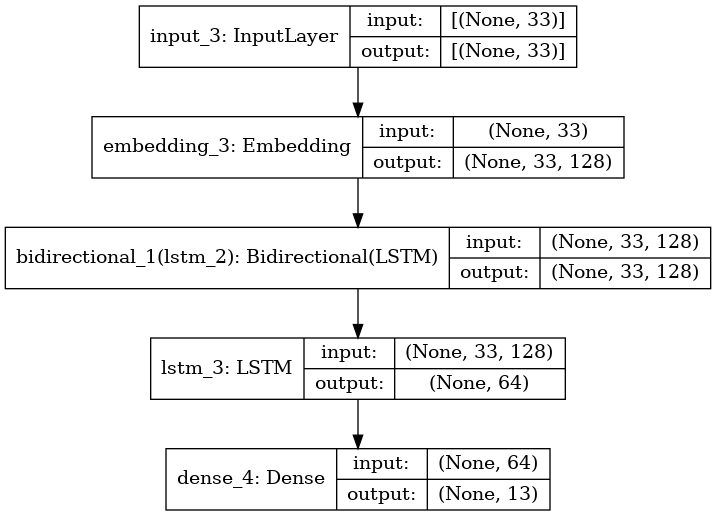

In [25]:
''' Normal_RNN_Model '''

import keras_tuner as kt
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2)


    
input_1 = tf.keras.layers.Input(shape=(x_train.shape[-1],))
embd_1 = tf.keras.layers.Embedding(input_dim = len(list(word_index)) + 1, output_dim=128)(input_1)
bi_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True, dropout=0.3, recurrent_dropout=0.5), merge_mode = 'concat')(embd_1)
lstm_1 = tf.keras.layers.LSTM(units=64, dropout=0.3, recurrent_dropout=0.5)(bi_1)
dense_1 = tf.keras.layers.Dense(len(all_classes), activation='softmax')(lstm_1)

model = tf.keras.models.Model(inputs = input_1, outputs = dense_1, name='Basic_RNN')
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes =True)

In [27]:
his2 = model.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=64, callbacks=[stop_early]) #, sample_weight = sample_weights)
print()
print(' -- Model_Evaluation -- ')
(model.evaluate(x_test, y_test))
tf.keras.models.save_model(model, filepath = "./basic_rnn.h5")

Epoch 1/50
1053/1053 [==============================] - 468s 444ms/step - loss: 1.9616 - accuracy: 0.3071 - val_loss: 1.4500 - val_accuracy: 0.4895
Epoch 2/50
1053/1053 [==============================] - 470s 446ms/step - loss: 1.1866 - accuracy: 0.5865 - val_loss: 1.0284 - val_accuracy: 0.6624
Epoch 3/50
1053/1053 [==============================] - 469s 445ms/step - loss: 0.7675 - accuracy: 0.7405 - val_loss: 0.8498 - val_accuracy: 0.7365
Epoch 4/50
1053/1053 [==============================] - 468s 444ms/step - loss: 0.5111 - accuracy: 0.8365 - val_loss: 0.7472 - val_accuracy: 0.7820
Epoch 5/50
1053/1053 [==============================] - 462s 438ms/step - loss: 0.3562 - accuracy: 0.8937 - val_loss: 0.7142 - val_accuracy: 0.8025
Epoch 6/50
1053/1053 [==============================] - 462s 439ms/step - loss: 0.2618 - accuracy: 0.9215 - val_loss: 0.7336 - val_accuracy: 0.8130
Epoch 7/50
1053/1053 [==============================] - 463s 440ms/step - loss: 0.2039 - accuracy: 0.9382 - val_

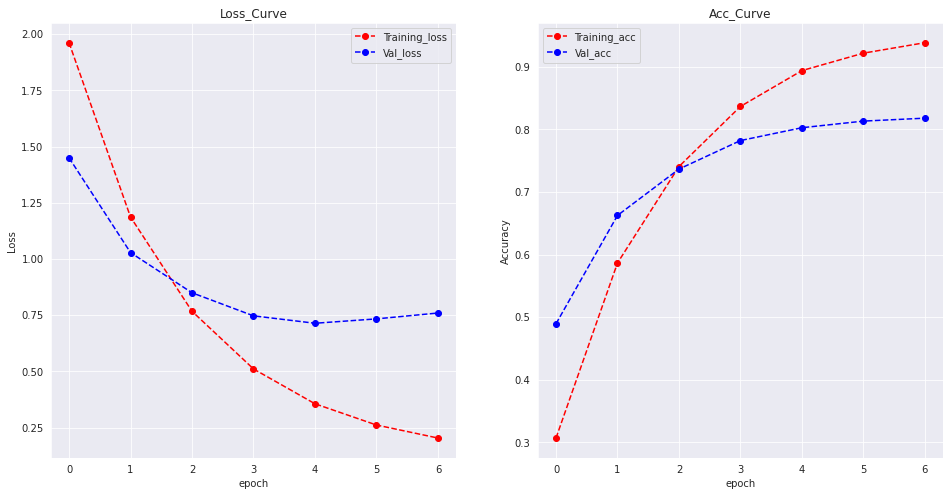


--Confusion_Matrix--

[[2025    0    0    5   10   50   43    6    1    0    7    0   53]
 [   8 2053    0    9   12   51   19    9    4    3    1    0   31]
 [   4   16 2181    2    0    9    8    2    0    0    3    0    4]
 [   3    1    0 1672  137  120   61   23   22    0   26    0   36]
 [   4   12    0  181 1522  318  121   31   59   16   47    0   67]
 [   8   15    0   80  177  698  284   38   43    5   46    0  158]
 [  17    0    0   33   49  257 1116    8    9    0   30    0  155]
 [   7    4    0   55   61  112   64 2015   14    2   13    0   33]
 [   2    2    0   28   35   79   35    1 2034    3   12    0   20]
 [   0    5    0    8    7   56   11    0    8 2088    6    0   16]
 [   9    4    0   52   55  186   89    4   16    1 1867    0   85]
 [   2    3    0    4    2    6    8    0    0    0    3 2081    8]
 [  43    3    0   68   57  276  353   25   23    5   46    0 1520]]

f1_score:  0.8147039965804659
Pr.:  0.8147039965804659
Re.:  0.8147039965804659


In [28]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

his_2 = his2.history

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].set_title('Loss_Curve')
ep = range(len(his_2['loss']))
axs[0].plot(ep, his_2['loss'],'o--r',label = 'Training_loss')
axs[0].plot(ep, his_2['val_loss'],'o--b',label = 'Val_loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Acc_Curve')
ep = range(len(his_2['loss']))
axs[1].plot(ep, his_2['accuracy'],'o--r',label = 'Training_acc')
axs[1].plot(ep, his_2['val_accuracy'],'o--b',label = 'Val_acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

print()

ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=-1)
conf_matrix  = confusion_matrix(ypred, y_test)

print('--Confusion_Matrix--')
print()
print(conf_matrix)
print()
print('f1_score: ',f1_score(y_test, ypred, average='micro'))
print('Pr.: ',precision_score(y_test, ypred, average='micro'))
print('Re.: ',recall_score(y_test, ypred, average='micro'))

<h2 style="background-color:black; color:white; text-align:center;"><b>Inference |<i>  Basic_RNN </i></b></h2> 

In [31]:
## inference
import random

index = {}
for val, key in enumerate(word_index.keys()):
    index[val+1] = key 
inv_word_index = index
inv_word_index[0] = ''


def reverser(inp):
    st = ''
    for i in inp:
        st += ' ' + str(inv_word_index.get(i))
    return st

def predict():
    seed = random.randint(0, x_test.shape[0])
    x_seed = x_test[seed]
    act = y_test[seed]
    st = reverser(x_seed)
    print('Input_Sentence: ', st)
    print('--'*20)
    print('Actual_emotion: ', inv_label_index.get(act))
    pred = (np.argmax(model.predict(x_seed.reshape(1,-1)), axis=-1).tolist())
    print('--'*20)
    print('Predicted_emotion: ', inv_label_index.get(pred[-1]))

for _ in range(5):
    print('**'*50)
    predict()
    print('**'*50)
    print()

****************************************************************************************************
Input_Sentence:   starting an account here on twitter                           
----------------------------------------
Actual_emotion:  neutral
----------------------------------------
Predicted_emotion:  enthusiasm
****************************************************************************************************

****************************************************************************************************
Input_Sentence:   sarahjlwest i ake it youre at work then and not lazing at home on a sunny bank holiday               
----------------------------------------
Actual_emotion:  empty
----------------------------------------
Predicted_emotion:  empty
****************************************************************************************************

****************************************************************************************************
Input_Sentence:   yvett

<h2 style="background-color:black; color:white; text-align:center;"><b>Model Creation & Training |<i>  Transformer </i></b></h2> 

In [12]:
## Transformer_architecture
import tensorflow as tf

class T_encoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, embd_dim, dense_dim, num_classes , **kwargs):
        super(T_encoder, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embd_dim = embd_dim
        self.dense_dim = dense_dim
        self.multi_head_layer = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embd_dim)
        
        self.dense_layer = tf.keras.models.Sequential([
            tf.keras.layers.Dense(dense_dim, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(embd_dim)])
        
        self.norm_layer_1 = tf.keras.layers.LayerNormalization()
        self.norm_layer_2 = tf.keras.layers.LayerNormalization()
        self.Final_Dense = tf.keras.layers.Dense(num_classes, activation = 'softmax')
        self.supports_mask = True
    

    def call(self, inputs, mask=None): ## we mask the padding in encoder model
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype='int32') ## because attention is 5-D tensor 
        att_output = self.multi_head_layer(query = inputs, value = inputs, key = inputs, attention_mask = padding_mask)# (all vals) after instantiating pass query, value and key
        att_output = tf.keras.layers.Dropout(0.5)(att_output)
        output_1 = self.norm_layer_1(att_output + inputs)
        
        dense_output = self.dense_layer(output_1)
        output_2 = self.norm_layer_2(dense_output + output_1)
        fl_output = tf.keras.layers.Flatten()(output_2)
        encoder_output = self.Final_Dense(fl_output)
        
        return encoder_output
        
class positional_encoding(tf.keras.layers.Layer):
    def __init__(self, inp_dim , max_seq_len, embd_dim, **kwargs):
        super(positional_encoding, self).__init__(**kwargs)
        self.inp_dim = inp_dim
        self.max_seq_len = max_seq_len
        self.embd_dim = embd_dim
        self.embd_layer = tf.keras.layers.Embedding(input_dim = inp_dim, output_dim = embd_dim)
        self.pos_layer = tf.keras.layers.Embedding(input_dim = max_seq_len, output_dim = embd_dim)
        
    def call(self, inputs):
        embd_output_1 = self.embd_layer(inputs)
        pos_in = tf.range(start = 0, limit = self.max_seq_len, delta =1)
        pos_output_1 = self.pos_layer(pos_in)
        model_input = embd_output_1 + pos_output_1
        return model_input
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0) ## for masking out the padding in encoder_input


In [13]:
### AdamW is an optimizer which decays based on training steps 
import tensorflow_addons as tfa
'''
step = tf.Variable(0)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
lr = 1e-1 * schedule(step) ## learning_rate
wd = lambda: 1e-4 * schedule(step) ## weight_deacays
'''
### Learning Rate Scheduler decays lr based on epochs
def sec(epoch, learning_rate):
    if epoch <= 2:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.9)

lrs = tf.keras.callbacks.LearningRateScheduler(sec)
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

Best_embd_dim:  256
Best_num_heads:  4
Best_dense_dim:  176
Best_Learning_Rate:  0.001
Model: "Transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
positional_encoding (positio (None, 33, 256)           12442368  
_________________________________________________________________
t_encoder (T_encoder)        (None, 13)                1253309   
Total params: 13,695,677
Trainable params: 13,695,677
Non-trainable params: 0
_________________________________________________________________


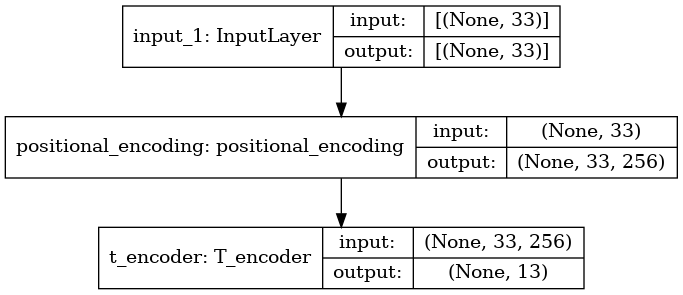

In [16]:
import keras_tuner as kt
embd_dim = 64
num_heads = 2
dense_dim = 64
num_classes = len(all_classes)

def tuner_model(hp):
    hp_embd_dim = hp.Int('embd_dim', min_value = 16, max_value = 512, step = 16)
    hp_num_heads = hp.Int('num_heads', min_value = 2, max_value = 10, step = 2)
    hp_dense_dim = hp.Int('dense_dim', min_value = 16, max_value = 512, step = 16)
    hp_lr = hp.Choice('lr', values = [1e-2, 1e-3, 1e-4])
    
    inp_1  = tf.keras.layers.Input(shape=(x_train.shape[-1], ))
    pos_op = positional_encoding(inp_dim = len(list(word_index))+1, max_seq_len = max_inp_len, embd_dim = hp_embd_dim )(inp_1)
    enc_op = T_encoder(num_heads = hp_num_heads , embd_dim = hp_embd_dim, dense_dim = hp_dense_dim, num_classes = num_classes)(pos_op)

    transformer = tf.keras.models.Model(inputs = inp_1, outputs = enc_op, name = 'Transformer')
    transformer.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = hp_lr), metrics = ['accuracy'])
    return transformer

tuner = kt.Hyperband(tuner_model, objective = 'loss', max_epochs = 3)

tuner.search(x_train, y_train, epochs=5, callbacks=[stop_early, lrs])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print('Best_embd_dim: ', best_hps['embd_dim'])
print('Best_num_heads: ', best_hps['num_heads'])
print('Best_dense_dim: ', best_hps['dense_dim'])
print('Best_Learning_Rate: ', best_hps['lr'])

best_transformer = tuner.hypermodel.build(best_hps)

best_transformer.summary()
tf.keras.utils.plot_model(best_transformer, show_shapes = True)

(84220, 33) (84220,)

-- Evaluation --
878/878 [==============================] - 3s 4ms/step - loss: 0.6796 - accuracy: 0.8548



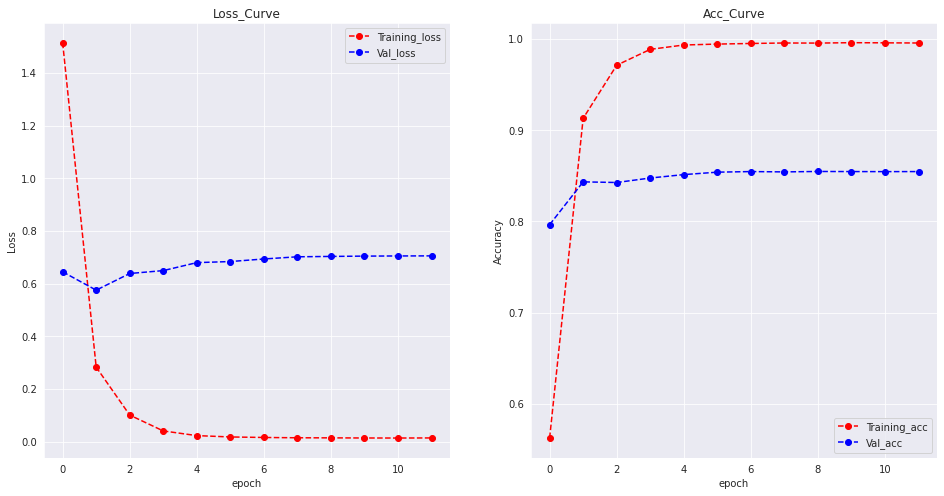

In [19]:
print(x_train.shape, y_train.shape)
his2 = best_transformer.fit(x_train, y_train, epochs=50, validation_split=0.2, batch_size=128, callbacks = [stop_early, lrs]) ## Learining_rate_scheduler helps in controlling your loss
print()
print('-- Evaluation --')
best_transformer.evaluate(x_test, y_test)
print()
his_2 = his2.history

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].set_title('Loss_Curve')
ep = range(len(his_2['loss']))
axs[0].plot(ep, his_2['loss'],'o--r',label = 'Training_loss')
axs[0].plot(ep, his_2['val_loss'],'o--b',label = 'Val_loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Acc_Curve')
ep = range(len(his_2['loss']))
axs[1].plot(ep, his_2['accuracy'],'o--r',label = 'Training_acc')
axs[1].plot(ep, his_2['val_accuracy'],'o--b',label = 'Val_acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

ypred = best_transformer.predict(x_test)
ypred = np.argmax(ypred, axis=-1)
conf_matrix  = confusion_matrix(ypred, y_test)

print('--Confusion_Matrix--')
print()
print(conf_matrix)
print()
print('f1_score: ',f1_score(y_test, ypred, average='micro'))
print('Precsion: ',precision_score(y_test, ypred, average='micro'))
print('Recall: ',recall_score(y_test, ypred, average='micro'))

--Confusion_Matrix--

[[2100    0    0   16    8   36   47    8    0    0    3    0   37]
 [   0 2112    0   11    4   23    7    5    0    0    0    0   10]
 [   0    0 2181    0    0    1    2    0    0    0    0    0    1]
 [   0    0    0 1782  110  151   57    7   19    0   14    0   31]
 [   2    0    0  126 1573  246   96   19   16    0   12    0   56]
 [   3    0    0  108  203  947  328   33   47    0   46    0  175]
 [   8    0    0   44   78  359 1360   10   14    0   26    0  191]
 [   3    0    0   22   25   52   37 2067   12    0    8    0   17]
 [   0    0    0   19   43   64   22    2 2106    0    3    0   16]
 [   0    6    0    6   14   35   10    0    2 2123    1    0    2]
 [   4    0    0   28   30   93   50    1    5    0 1969    0   51]
 [   0    0    0    0    0    2    3    0    0    0    3 2081    2]
 [  12    0    0   35   36  209  193   10   12    0   22    0 1597]]

f1_score:  0.8548122818266011
Precsion:  0.8548122818266011
Recall:  0.8548122818266011


<h2 style="background-color:black; color:white; text-align:center;"><b>Inference |<i>  Transformer </i></b></h2> 

In [23]:
## inference
import random

index = {}
for val, key in enumerate(word_index.keys()):
    index[val+1] = key 
inv_word_index = index
inv_word_index[0] = ''


def reverser(inp):
    st = ''
    for i in inp:
        st += ' ' + str(inv_word_index.get(i))
    return st

def predict():
    seed = random.randint(0, x_test.shape[0])
    x_seed = x_test[seed]
    act = y_test[seed]
    st = reverser(x_seed)
    print('Input_Sentence: ', st)
    print('--'*20)
    print('Actual_emotion: ', inv_label_index.get(act))
    pred = (np.argmax(best_transformer.predict(x_seed.reshape(1,-1)), axis=-1).tolist())
    print('--'*20)
    print('Predicted_emotion: ', inv_label_index.get(pred[-1]))

for _ in range(5):
    print('**'*50)
    predict()
    print('**'*50)
    print()

****************************************************************************************************
Input_Sentence:   suffering benadryl hangover this morning and a killer headache ugh                       
----------------------------------------
Actual_emotion:  hate
----------------------------------------
Predicted_emotion:  hate
****************************************************************************************************

****************************************************************************************************
Input_Sentence:   olafsearson lol i could try seriously tho dont do all of it that sucks xx                  
----------------------------------------
Actual_emotion:  anger
----------------------------------------
Predicted_emotion:  anger
****************************************************************************************************

****************************************************************************************************
Input_Sentence: